# Convolutional Neural Networks in Pytorch

If you are planning to use `pytorch` on the workstations installed in the Department of Computer Science, you must execute this command

`export PYTHONPATH=$PYTHONPATH:/usr/local/anaconda3/latest/lib/python3.8/site-packages/`

A better solution is to add it to your startup script, such as `.bashrc`.

A more complete example of implementing a convolutional network in Pytorch is [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [1]:
# Modified from https://github.com/vinhkhuc/PyTorch-Mini-Tutorials

import numpy as np

import torch
from torch.autograd import Variable

import time

import gzip
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In our `numpy` version of a CNN, the constructor was called like
```python
    patch_size = 5
    nnet = NeuralNetworkClassifierCNN(28*28, [2, 2], len(np.unique(T)),
                                      patch_size=patch_size, stride=2)
```

Let's define our `pytorch` version with a contructor that is called like
```python
    nnet = ConvNet(28*28, n_hiddens_per_conv_layer=[4, 2], n_hiddens_per_fc_layer=[10], len(np.unique(T)),
                   patch_size_per_conv_layer=[5, 4], stride_per_conv_layer=[2, 2])                   
```

In [2]:
import numpy as np
import torch
        
class ConvNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, 
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):
        
        super().__init__()
        
        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers or
            len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')
        
        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu
        
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append( torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride) )
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append( torch.nn.Linear(n_in, nh) )
            n_in = nh
        self.fc_layers.append( torch.nn.Linear(n_in, n_outputs) )
        
        self.to(self.device)


    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append( self.activation_function(conv_layer(Ys[-1])) )

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append( self.activation_function(fc_layer(Ys[-1].reshape(n_samples, -1))) )
            else:
                Ys.append( self.activation_function(fc_layer(Ys[-1])) )

        Ys.append(self.fc_layers[-1](Ys[-1]))
        return Ys


    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]
    

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        
        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch
            
        X.requires_grad_(True)

        self.classes = torch.unique(T)
        
        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []
        
        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0
            
            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]
                
                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self


    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y


    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        Y = self.forward(X)
        probs = self.softmax(Y)
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()]
        return classes.cpu().numpy(), probs.detach().cpu().numpy()

In [13]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [14]:
!nvidia-smi

Tue Oct 12 11:46:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      8MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1] 
Xtest = test_set[0]
Ttest = test_set[1] 

# Convolutional nets in pytorch require reshaping the input matrices
Xtrain_cnn = Xtrain.reshape(-1, 1, 28, 28)
Xtest_cnn = Xtest.reshape(-1, 1, 28, 28)

In [20]:
cnnet = ConvNet(28 * 28, [10, 20], [5], 10,
               patch_size_per_conv_layer=[5, 7], stride_per_conv_layer=[2, 2], device=device)
# cnnet.to(device)


n_epochs = 1000
batch_size = 1000
learning_rate = 0.001
cnnet.train(Xtrain_cnn, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 100 Loss 0.044
adam: Epoch 200 Loss 0.009
adam: Epoch 300 Loss 0.003
adam: Epoch 400 Loss 0.002
adam: Epoch 500 Loss 0.002
adam: Epoch 600 Loss 0.002
adam: Epoch 700 Loss 0.001
adam: Epoch 800 Loss 0.001
adam: Epoch 900 Loss 0.001
adam: Epoch 1000 Loss 0.001


ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=180, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

In [21]:
Classes_pytorch, _ = cnnet.use(Xtest_cnn)
perc_pytorch = 100 * np.mean(Classes_pytorch == Ttest)
perc_pytorch

96.55

In [22]:
list(cnnet.children())[0][0]

Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))

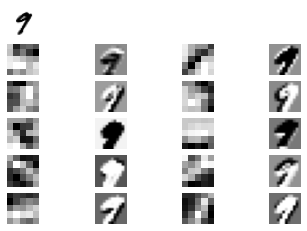

In [23]:
x = Xtest_cnn[20:21]
x = torch.from_numpy(x).float().to(device)
Ys = cnnet.forward_all_outputs(x)
layer1weights = list(cnnet.children())[0][0].weight.data

plt.subplot(6, 4, 1)
plt.imshow(-x.squeeze().cpu(), cmap='gray')
plt.axis('off')

ploti = 4
for i in range(10):
    ploti += 1
    plt.subplot(6, 4, ploti)
    plt.imshow(layer1weights[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(6, 4, ploti)
    plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

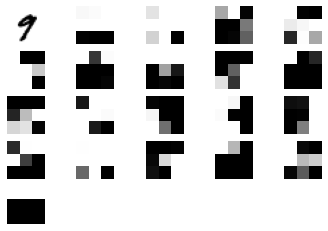

In [24]:
layer2weights = list(cnnet.children())[1][0].weight.data

plt.subplot(5, 5, 1)
plt.imshow(-x.squeeze().cpu(), cmap='gray')
plt.axis('off')

ploti = 1
for i in range(20):
    ploti += 1
    plt.subplot(5, 5, ploti)
    plt.imshow(Ys[2][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

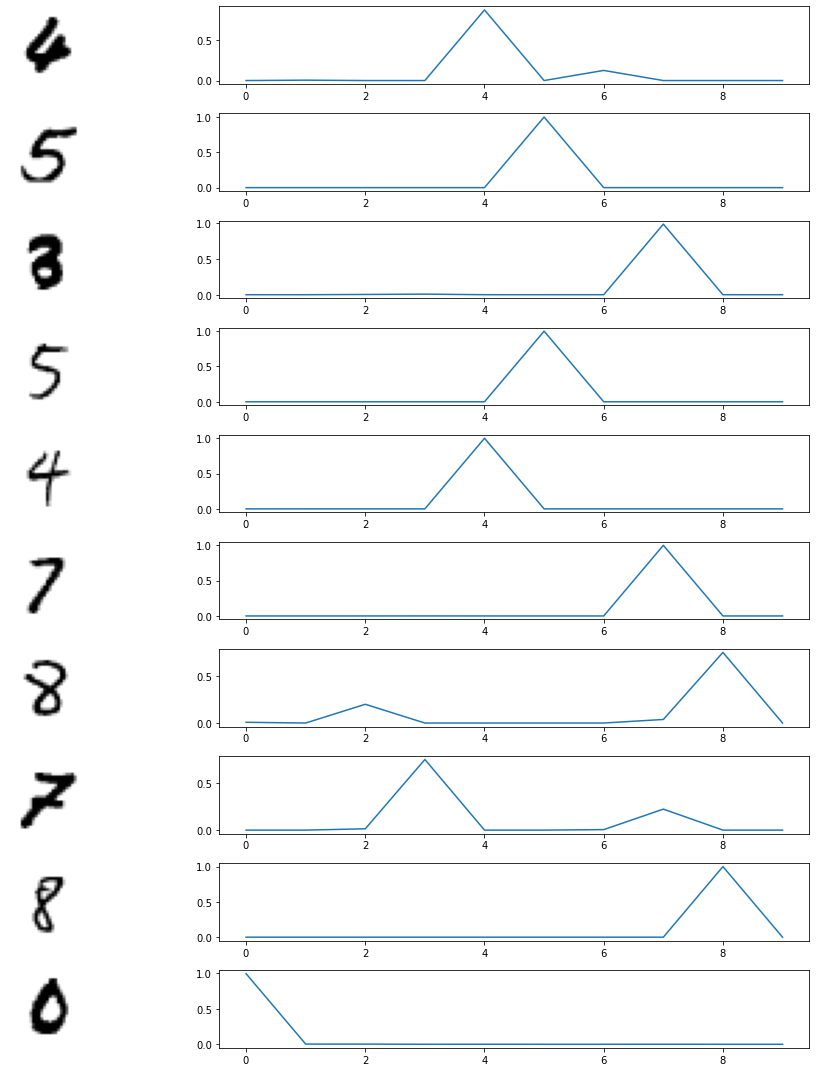

In [29]:
first = np.random.randint(5000)

x = Xtest_cnn[first:first + 10]
Classes, Probs = cnnet.use(x)

plt.figure(figsize=(15, 15))
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(10, 2, ploti)
    plt.imshow(-x[i, 0, :, :], cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 2, ploti)
    # Try calculating this my self
    Yprobs = Probs[i, :]
    plt.plot(Yprobs)
plt.tight_layout()